<a href="https://colab.research.google.com/github/angelinux/pneumonia-detector/blob/master/Pneumonia_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning and Pneumonia Detection

This simple jupyter notebook shows how to use transfer learning from inception model to classify pneumonia images in a kaggle dataset

## Library loading

In [2]:
import sys
import os
import argparse

import random

import time
import datetime

from collections import Counter

import numpy as np
import pandas as pd

import shutil
from tqdm import tqdm

import inspect
import gc

import re

from PIL import Image
import cv2

import keras

from keras.utils import np_utils

from keras.preprocessing.image import ImageDataGenerator

from keras import models
from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, GlobalAveragePooling1D, GlobalAveragePooling2D, Flatten, BatchNormalization, Dense


from keras.applications.inception_v3 import InceptionV3


from keras.constraints import maxnorm


from keras import optimizers
from keras.optimizers import Adam, SGD , RMSprop


from keras import backend as K
#K.set_image_dim_ordering('th')


from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau

from keras.wrappers.scikit_learn import KerasClassifier


from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report


from mlxtend.plotting import plot_confusion_matrix

import tensorflow as tf



from IPython.display import display

import seaborn as sns

from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

Using TensorFlow backend.


## Useful functions

In [0]:
# print date and time for given type of representation
def date_time(x):
    if x==1:
        return 'Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==2:    
        return 'Timestamp: {:%Y-%b-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==3:  
        return 'Date now: %s' % datetime.datetime.now()
    if x==4:  
        return 'Date today: %s' % datetime.date.today()

# prints a integer for degugging
def debug(x):
    print("-"*40, x, "-"*40)

    
# Removes everything except alphabetical and selected characters from name string
def name_correct(name):
    return re.sub(r'[^a-zA-Z,:]', ' ', name).title() 
  
# Creates directory, if directory exists removes if remove parameter is set to True 
def create_directory(directory_path, remove=False):
    if remove and os.path.exists(directory_path):
        try:
            shutil.rmtree(directory_path)
            os.mkdir(directory_path)
        except:
            print("Could not remove directory : ", directory_path)
            return False
    else:
        try:
            os.mkdir(directory_path)
        except:
            print("Could not create directory: ", directory_path)
            return False
        
    return True

# Removes directory, if directory exists 
def remove_directory(directory_path):
    if os.path.exists(directory_path):
        try:
            shutil.rmtree(directory_path)
        except:
            print("Could not remove directory : ", directory_path)
            return False
        
    return True
        
        
def dir_file_count(directory):
    return sum([len(files) for r, d, files in os.walk(directory)])
  
def get_reset_subplot_params(nrows, ncols, dpi):
    subplot_params = {}
    subplot_params["nrows"] = nrows
    subplot_params["ncols"] = ncols

    subplot_params["figsize_col"] = subplot_params["ncols"]*2.5
    subplot_params["figsize_row"] = subplot_params["nrows"]*2.5
    subplot_params["dpi"] = dpi
    subplot_params["facecolor"] = 'w'
    subplot_params["edgecolor"] = 'k'
    subplot_params["subplot_kw"] = {'xticks': [], 'yticks': []}
    subplot_params["axes.titlesize"] = 'small'
    subplot_params["hspace"] = 0.5
    subplot_params["wspace"] = 0.3
    
    return subplot_params

def get_reset_plot_params(figsize=(15, 5), title="", xlabel ="", ylabel="", legends=[], title_fontsize = 18, label_fontsize = 14, image_file_name="", save = False, dpi=100, update_image=True):
    plot_params = {}
    
    plot_params["figsize"] = figsize
    
    plot_params["title"] = title
    
    plot_params["xlabel"] = xlabel
    plot_params["ylabel"] = ylabel
    
    plot_params["legends"] = legends 
    
    plot_params["title_fontsize"] = title_fontsize
    plot_params["axes.titlesize"] = "small"
    plot_params["label_fontsize"] = label_fontsize
    
    plot_params["image_file_name"] = image_file_name
    plot_params["save"] = save
    plot_params["update_image"] = update_image
    
    plot_params["subplot"] = None
    return plot_params


## Download and clean data

In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia.zip
!unzip chest_xray.zip

In [0]:
input_directory = r"chest_xray/"
training_dir = input_directory + r"train"
validation_dir = input_directory + r"val"
testing_dir = input_directory + r"test"

for f in os.listdir(input_directory):
  if f.startswith('.'):
    print(input_directory+'/'+f)
    os.remove(input_directory+'/'+f)
  else :
    for f2 in os.listdir(input_directory+'/'+f):
      if f2.startswith('.'):
        print(f2)
        os.remove(input_directory+'/'+f+'/'+f2)


In [0]:
def select_image_by_category(image_dir, image_count_per_category):
    classes = os.listdir(image_dir)
    class_count = len(classes)

    image_file_paths = {}
    
    for i in range(class_count):
        subdir_path = image_dir+"/"+classes[i]
        subdir_files = os.listdir(subdir_path)

        subdir_file_count = len(subdir_files)

        subdir_file_mem = {}
        
        subdir_file_index = -1
        
        image_file_paths[classes[i]] = []
        
        for j in range(image_count_per_category):
            while subdir_file_index in subdir_file_mem:
                subdir_file_index = random.randint(0, subdir_file_count-1)
                
            subdir_file_mem[subdir_file_index] = 1
            
            subdir_file_name = subdir_files[subdir_file_index]
            subdir_file_path = subdir_path+ "/" + subdir_file_name

            image_file_paths[classes[i]].append(subdir_file_path)
            
    return image_file_paths


def get_fig_axs(subplot_params):
    fig, axs = plt.subplots(
        nrows=subplot_params["nrows"], ncols=subplot_params["ncols"], 
        figsize=(subplot_params["figsize_col"], subplot_params["figsize_row"]),
        dpi=subplot_params["dpi"], facecolor=subplot_params["facecolor"], 
        edgecolor=subplot_params["edgecolor"], subplot_kw=subplot_params["subplot_kw"])
        
    return fig, axs
    

def plot_sample_image(image_file_paths, plot_params, subplot_params, update_image=True):
    fig, axs = get_fig_axs(subplot_params)

    plt.rcParams.update({'axes.titlesize': plot_params["axes.titlesize"]})
    plt.subplots_adjust(hspace=subplot_params["hspace"], wspace=subplot_params["wspace"])


    i=0
    for img_filepath in image_file_paths:
        img = cv2.imread(img_filepath, 1)        
        plt.subplot(subplot_params["nrows"], subplot_params["ncols"], i+1)
        plt.title(img_filepath.split("/")[-1])
        plt.imshow(img)
        
        plt.xticks([])
        plt.yticks([])
        
        i=i+1
        
    if plot_params["update_image"] and os.path.exists(plot_params["image_file_name"]):
        os.remove(plot_params["image_file_name"])  
    if plot_params["save"]:
        fig.savefig(plot_params["image_file_name"], dpi=plot_params["dpi"])
        
    plt.tight_layout()
    plt.show()
    
    
def show_class_sample_images(directory, image_count_per_category=5, save=False, dpi=100, update_image=False):
    class_count = len(os.listdir(directory))
    print("Number of Class: ", class_count)
    sample_img_by_class = select_image_by_category(directory, image_count_per_category)
    for class_name in sample_img_by_class:
        plot_params = get_reset_plot_params(image_file_name="img.png", save = save, dpi=dpi, update_image=update_image)
        subplot_params = get_reset_subplot_params(nrows=1, ncols=image_count_per_category, dpi=dpi)
        print("%s%s%s"%("-"*55, name_correct(class_name), "-"*55))
        plot_sample_image(sample_img_by_class[class_name], plot_params, subplot_params)
        print("")
    print("%s%s%d%s"%("-"*55, "All Class Printed:", class_count, "-"*55))
    
# count number of files in each subdirectory of a directory
def subdirectory_file_count(master_directory):
    subdirectories = os.listdir(master_directory)
    subdirectory_count = len(subdirectories)

    subdirectory_names = []
    subdirectory_file_counts = []

    for subdirectory in subdirectories:
        current_directory = os.path.join(master_directory, subdirectory)
        file_count = len(os.listdir(current_directory))
        subdirectory_names.append(subdirectory)
        subdirectory_file_counts.append(file_count)
    
    return subdirectory_names, subdirectory_file_counts
         
    

# show barplot
def bar_plot(x, y, plot_property):
    if plot_property['subplot']:
        plt.subplot(plot_property['subplot'])
    sns.barplot(x=x, y=y)
    plt.title(plot_property['title'], fontsize=plot_property['title_fontsize'])
    plt.xlabel(plot_property['xlabel'], fontsize=plot_property['label_fontsize'])
    plt.ylabel(plot_property['ylabel'], fontsize=plot_property['label_fontsize'])
    plt.xticks(range(len(x)), x)
    
# show bar plot for count of labels in subdirectory of a directory
def count_bar_plot(master_directory, plot_property):
    dir_name, dir_file_count = subdirectory_file_count(master_directory)
    x = [name_correct(i) for i in dir_name]
    # x = dir_name
    y = dir_file_count
    bar_plot(x, y, plot_property)
    
    
# show bar plot for count of labels in subdirectory of a training, validation, testing directory    
def show_train_val_test(training_dir, validation_dir, testing_dir, plot_property):
    plt.figure(figsize=plot_property['figsize'])
    
    title = plot_property['title']
    plot_property['title'] = title + " (Training)"
    subplot_no = plot_property['subplot'] 

    count_bar_plot(training_dir, plot_property)
    
    
    plot_property['title'] = title + " (Validation)"
    plot_property['subplot'] = subplot_no+1
    count_bar_plot(validation_dir, plot_property)
    
    
    plot_property['title'] = title + " (Testing)"
    plot_property['subplot'] = subplot_no + 2
    count_bar_plot(testing_dir, plot_property)
    
    plt.show()
    
# reset tensorflow graph tp free up memory and resource allocation 
def reset_graph(model=None):
    if model:
        try:
            del model
        except:
            return False
    
    tf.reset_default_graph()
    
    K.clear_session()
    
    gc.collect()
    
    return True


# reset callbacks 
def reset_callbacks(checkpoint=None, reduce_lr=None, early_stopping=None, tensorboard=None):
    checkpoint = None
    reduce_lr = None
    early_stopping = None
    tensorboard = None

## Visualization of sample data with its classification and balance between classes

Number of Class:  2
-------------------------------------------------------Normal-------------------------------------------------------


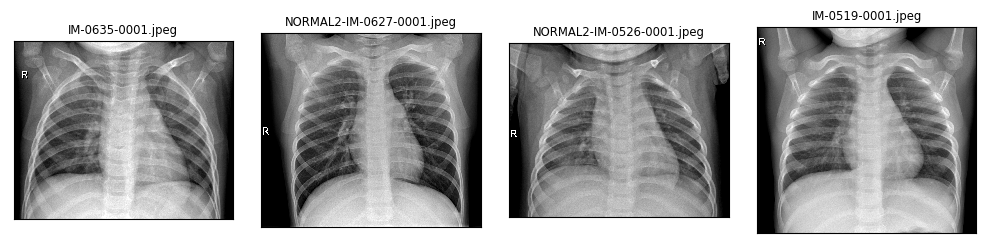


-------------------------------------------------------Pneumonia-------------------------------------------------------


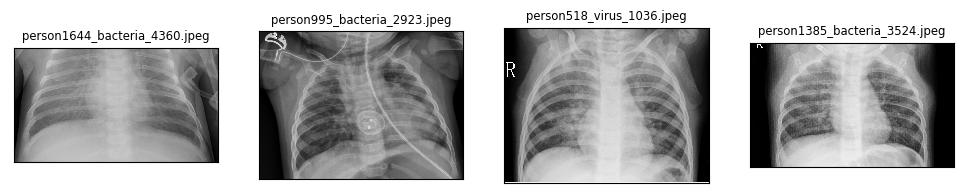


-------------------------------------------------------All Class Printed:2-------------------------------------------------------


In [7]:
show_class_sample_images(training_dir, 4)

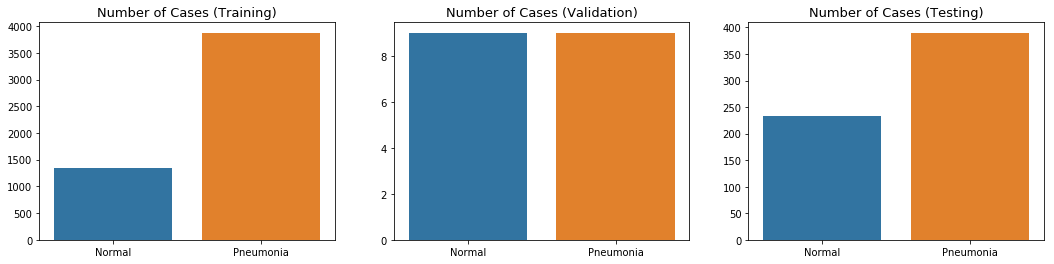

In [8]:
plot_params = get_reset_plot_params()

plot_params['figsize'] = (18,4)

plot_params['title_fontsize'] = 13
plot_params['label_fontsize'] = 10

plot_params['title'] = "Number of Cases"

plot_params['subplot'] = 131

show_train_val_test(training_dir, validation_dir, testing_dir, plot_params)
classes = os.listdir(training_dir)
classes = [name_correct(i) for i in classes]

## Preparing train, validation and testing sets

In [9]:


rescale = 1./255
target_size = (150, 150)
batch_size = 163
class_mode = "categorical"


train_datagen = ImageDataGenerator(
    rescale=rescale,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)


train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size,
    shuffle=True)


validation_datagen = ImageDataGenerator(rescale=rescale)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=dir_file_count(validation_dir),
    shuffle = False)


test_datagen = ImageDataGenerator(rescale=rescale)

test_generator = test_datagen.flow_from_directory(
    testing_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=dir_file_count(testing_dir),
    shuffle = False)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [10]:
model_dir = 'output/models/'
os.makedirs(model_dir, exist_ok=True)
model_file = model_dir + "{epoch:02d}-val_acc-{val_acc:.2f}-val_loss-{val_loss:.2f}.hdf5"
log_dir = 'logs/'
create_directory(log_dir, remove=True)

True

In [11]:
reset_graph()
reset_callbacks()

In [12]:
print("Setting Callbacks at ", date_time(1))

checkpoint = ModelCheckpoint(
    model_file, 
    monitor='val_acc', 
    save_best_only=True)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True)


tensorboard = TensorBoard(
    log_dir=log_dir,
    batch_size=batch_size,
    update_freq = 'batch')


reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=5,
    cooldown=2,
    min_lr=0.0000000001,
    verbose=1)


#-----------------------------------------------------------------------------------------------------------------#
# callbacks = [checkpoint, reduce_lr, early_stopping, tensorboard]
callbacks = [checkpoint]
#-----------------------------------------------------------------------------------------------------------------#
print("Set Callbacks at ", date_time(1))

Setting Callbacks at  Timestamp: 2019-09-20 13:58:56
Set Callbacks at  Timestamp: 2019-09-20 13:58:57


In [13]:
from sklearn.utils import class_weight
def get_weight(y):
    class_weight_current =  class_weight.compute_class_weight('balanced', np.unique(y), y)
    return class_weight_current

  
class_weight = get_weight(train_generator.classes)
class_weight

array([1.9448173 , 0.67303226])

## Model definition

In [0]:
# Load and configure model InceptionV3 for fine-tuning with new class labels
def get_model():    
    
#     base_model = InceptionV3(weights=None, include_top=False)
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

    x = base_model.output
    
    x = Dropout(0.5)(x)
    
    x = GlobalAveragePooling2D()(x)
    #x = Dropout(0.2)(x)
    
    #x = Dense(512, activation='relu')(x)
    x = Dense(1024, activation='relu')(x)
    
    x = BatchNormalization()(x)
    
# #     predictions = Dense(2, activation='sigmoid')(x) 
    predictions = Dense(2, activation='softmax')(x) 
    
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    
    for layer in base_model.layers:
        layer.trainable = False
        
        
#     for layer in model.layers[:249]:
#         layer.trainable = False
#     for layer in model.layers[249:]:
#         layer.trainable = True
        
    
    model.summary()
        
    return model

In [28]:
model = get_model()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 74, 74, 32)   96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 74, 74, 32)   0           batch_normalization_95[0][0]     
____________________________________________________________________________________________

## Model training

In [29]:
print("Starting Training Model", date_time(1))


steps_per_epoch=len(train_generator)
validation_steps=len(validation_generator)

print(steps_per_epoch)
print(validation_steps)



# lr = 0.00001
# optimizer=optimizers.Adam(lr=lr)



optimizer=optimizers.Adam()
loss='categorical_crossentropy'
metrics=['accuracy']
#epochs = 50
epochs = 10

model.compile(optimizer, loss=loss, metrics=metrics)

history = model.fit_generator(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs=epochs,
    verbose=2,
    callbacks=callbacks,
    validation_data=validation_generator,
    validation_steps=validation_steps, 
    class_weight=class_weight)

print("Completed Model Training", date_time(1))

Starting Training Model Timestamp: 2019-09-20 09:32:59
32
1
Epoch 1/10
 - 88s - loss: 0.5822 - acc: 0.8227 - val_loss: 4.2958 - val_acc: 0.5625
Epoch 2/10
 - 81s - loss: 0.2522 - acc: 0.9036 - val_loss: 1.2177 - val_acc: 0.6875
Epoch 3/10
 - 82s - loss: 0.2322 - acc: 0.9103 - val_loss: 1.5845 - val_acc: 0.6250
Epoch 4/10
 - 81s - loss: 0.2217 - acc: 0.9110 - val_loss: 1.3041 - val_acc: 0.6875
Epoch 5/10
 - 80s - loss: 0.2055 - acc: 0.9187 - val_loss: 7.8929 - val_acc: 0.5000
Epoch 6/10
 - 81s - loss: 0.2144 - acc: 0.9172 - val_loss: 2.2613 - val_acc: 0.7500
Epoch 7/10
 - 55s - loss: 0.2043 - acc: 0.9187 - val_loss: 4.7609 - val_acc: 0.5000
Epoch 8/10
 - 81s - loss: 0.2162 - acc: 0.9145 - val_loss: 3.3732 - val_acc: 0.5000
Epoch 9/10
 - 81s - loss: 0.2035 - acc: 0.9216 - val_loss: 3.7868 - val_acc: 0.5625
Epoch 10/10
 - 81s - loss: 0.2004 - acc: 0.9193 - val_loss: 5.4248 - val_acc: 0.5000
Completed Model Training Timestamp: 2019-09-20 09:47:59


## Model evaluation

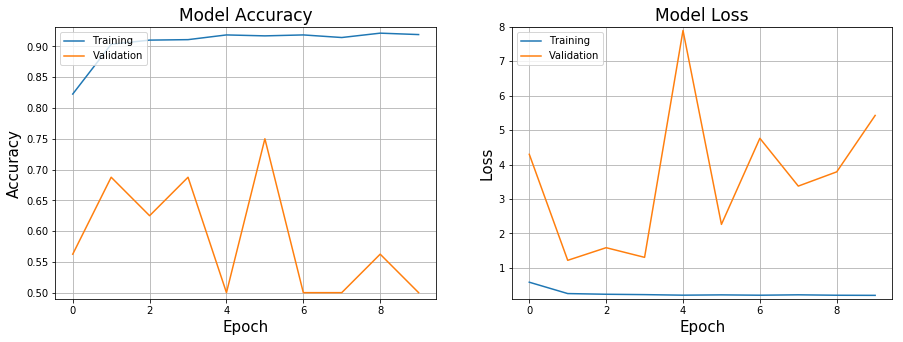

In [30]:
xlabel = 'Epoch'
legends = ['Training', 'Validation']

ylim_pad = [0.01, 0.1]


plt.figure(figsize=(15, 5))

# Plot training & validation Accuracy values

y1 = history.history['acc']
y2 = history.history['val_acc']

min_y = min(min(y1), min(y2))-ylim_pad[0]
max_y = max(max(y1), max(y2))+ylim_pad[0]


plt.subplot(121)

plt.plot(y1)
plt.plot(y2)

plt.title('Model Accuracy', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()

                         
# Plot training & validation loss values
    
y1 = history.history['loss']
y2 = history.history['val_loss']

min_y = min(min(y1), min(y2))-ylim_pad[1]
max_y = max(max(y1), max(y2))+ylim_pad[1]
    
    
plt.subplot(122)

plt.plot(y1)
plt.plot(y2)

plt.title('Model Loss', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()
                         
plt.show()


## Get the best performing model from personal google drive

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [14]:
model_file = '/content/drive/My Drive/03-val_acc-0.75-val_loss-1.27.hdf5'
model = keras.models.load_model(model_file)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Get Performance

In [15]:
numofbatch = len(test_generator)

print(numofbatch)

batch_no = random.randint(0, numofbatch-1)

y_img_batch, y_true_batch = test_generator[batch_no] 
y_true_batch = y_true_batch.argmax(axis=-1)

y_pred_batch = model.predict(y_img_batch)
y_pred_batch = y_pred_batch.argmax(axis=-1)


sizeofbatch = len(y_true_batch)
print("-"*35)
print("%s%d"%     ("Selected Batch No       : ", batch_no))
print("-"*35)
print("%s%d"%     ("Batch Size              : ", len(y_pred_batch)))
print("-"*35)
print("%s%.2f%s"% ("Accuracy                : ", np.mean(y_true_batch==y_pred_batch)*100, "%"))
print("-"*35)

1
-----------------------------------
Selected Batch No       : 0
-----------------------------------
Batch Size              : 624
-----------------------------------
Accuracy                : 76.60%
-----------------------------------


In [0]:
figure_directory = '/output/'
image_file_name_batch = figure_directory+"/result"
image_file_name_sample = figure_directory+"/sample"

batch_size_t = len(y_true_batch)

class_map = {v: k for k, v in test_generator.class_indices.items()}


dpi=100


ncols = 8
# ncols = batch_size_t if batch_size_t<ncols else ncols     
# nrows = batch_size_t/ncols
# nrows = int(batch_size_t/ncols)+1 if batch_size_t%ncols else  int(batch_size_t/ncols)
nrows = 4

count = ncols*nrows


subplot_params = get_reset_subplot_params(nrows, ncols, dpi)
plot_params = get_reset_plot_params()

In [0]:
def show_predictions(y_img_batch, y_true, y_pred, subplot_params, plot_params, class_map, testing_dir, image_file_name, count=8, sample=True):
    fig, axs = get_fig_axs(subplot_params)
    plt.rcParams.update({'axes.titlesize': plot_params["axes.titlesize"]})
    plt.subplots_adjust(hspace=subplot_params["hspace"], wspace=subplot_params["wspace"])
    
    file_names = test_generator.filenames
    m = {}
    length = len(y_true)
    for i in range(0, count): 
        num = i
        if sample:
            num = random.randint(0, length-1)
            while num in m:
                num = int(random.randint(0, length-1))

            m[num]=1


        plt.subplot(subplot_params["nrows"], subplot_params["ncols"], i+1)
        img = cv2.imread(testing_dir+"/"+ file_names[num], 1)
        plt.imshow(img)

        plt.xticks([])
        plt.yticks([])
        
        
        original = class_map[y_true[num]]
        predicted = class_map[y_pred[num]]
        
        
        title_text = ("%s%s%s%s%s"%("True: ", original, "\n", "Pred: ", predicted))
        
        if original==predicted:
            plt.title(title_text)
        else:
            plt.title(title_text, color='red')
            

        if plot_params["update_image"] and os.path.exists(image_file_name):
            os.remove(image_file_name)   

        #fig.savefig(image_file_name, dpi=subplot_params["dpi"])

    plt.tight_layout()
    plt.show()


## Show prediction on a batch of images

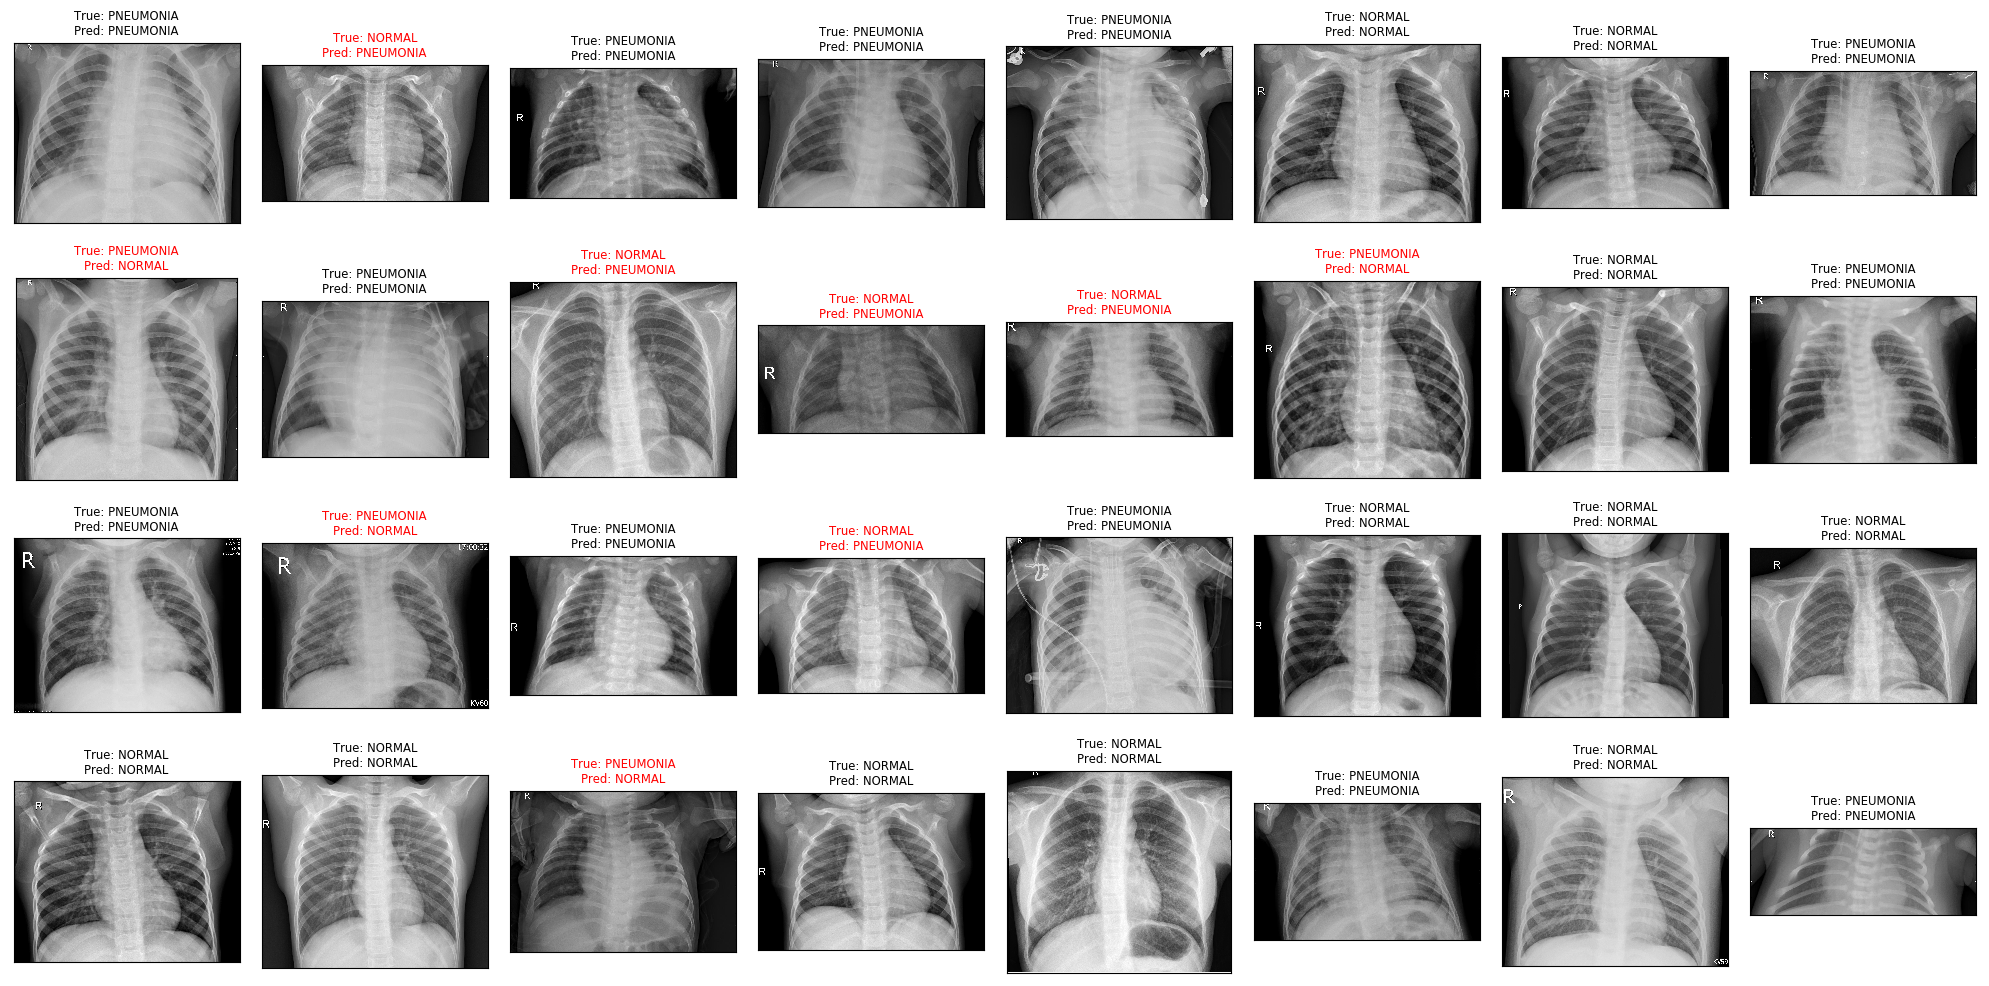

In [36]:
show_predictions(y_img_batch, y_true_batch, y_pred_batch, subplot_params, plot_params, class_map, testing_dir, image_file_name_batch, count=count, sample=True)


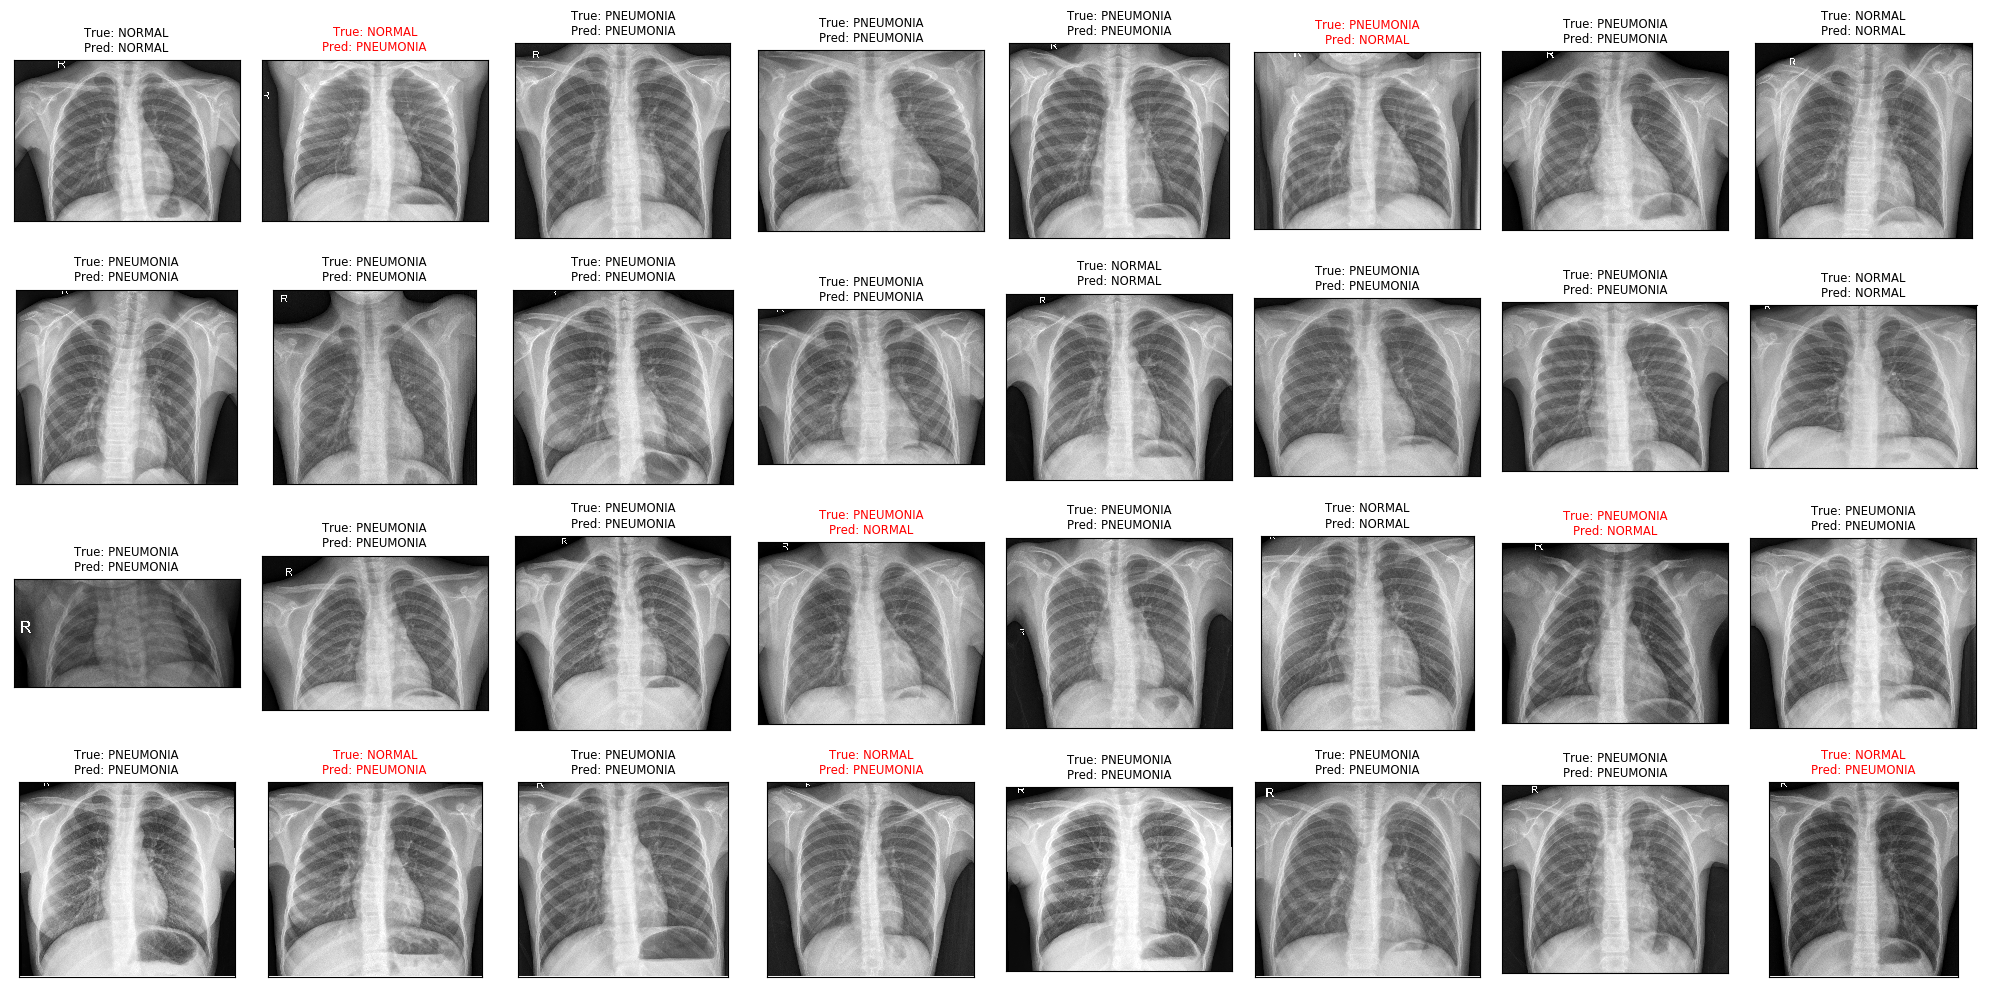

In [49]:
indexes = [random.randint(0, len(y_img_batch)-1) for j in range(count)]
y_img_batch_red = y_img_batch[indexes]
y_true_batch_red = y_true_batch[indexes]
y_pred_batch_red = y_pred_batch[indexes]
show_predictions(y_img_batch_red, y_true_batch_red, y_pred_batch_red, 
                 subplot_params, plot_params, class_map, testing_dir, 
                 image_file_name_batch, count=count, sample=False)

## Show prediction on a single random file

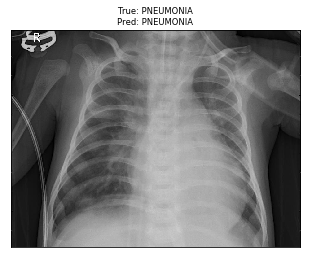

In [33]:
ind = random.randint(0, len(y_img_batch)-1)
file_name = test_generator.filenames[ind]
y_img_batch, y_true_batch = test_generator[batch_no] 
y_true_batch = y_true_batch.argmax(axis=-1)
ind_pred = model.predict(np.expand_dims(y_img_batch[ind], axis=0))
ind_pred = ind_pred.argmax(axis=-1)[0]
ind_true = y_true_batch[ind]

plt.figure()

img = cv2.imread(testing_dir+"/"+ file_name, 1)
plt.imshow(img)

plt.xticks([])
plt.yticks([])


original = class_map[ind_true]
predicted = class_map[ind_pred]


title_text = ("%s%s%s%s%s"%("True: ", original, "\n", "Pred: ", predicted))

if original==predicted:
    plt.title(title_text)
else:
    plt.title(title_text, color='red')
    